# Muon lifetime

This experiment in the Higher Year Lab measures the decay time of muons. The muons are produced in the upper atmosphere by energetic nuclei of cosmic origin colliding with atmospheric nuclei. Some muons will reach the ground and pass though a plastic scintillator in the lab. When they enter, they cause a light pulse, and if they decay in the scintillator, they cause another light pulse. The time interval between these pulses is recorded, and measures the lifetime of one particular muon. By recording many hundreds of such pulses we start to see an exponential decay in the number of counts per time interval, as a function of time. We can use this to determine the muon half-life. 

An interesting question: if we see a muon decaying in the scintillator, the muon must have been in existence before it entered the scintillator, so its actual age when it decayed is longer that the time between the two light pulses. How do we allow for that? Understanding this is fundamental!

It turns out that there are lots of subtleties in analysing the results from this experiment. This Jupyter Notebook explores some of them.

  30 bins, with width dt = 0.667 microseconds


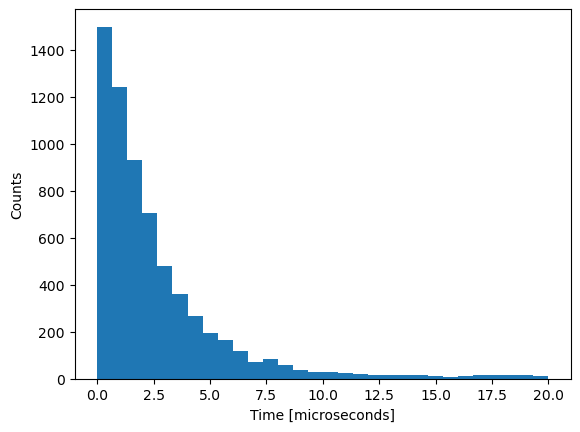

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

# Begin by read the data, taken by students in June 2019. The file
# has two columns: the first is the decay time in nanoseconds, the
# second column is the time since the UNIX epoch in seconds. We only
# use the first column.
#
# Here are the first 6 rows of a typical data file:
#
# 480 1560385853
# 960 1560385868
# 5800 1560385870
# 2240 1560385876
# 1460 1560385905
# 3440 1560385911

# The following line reads the data from the given URL, and puts it in
# a 2D numpy array, where the first index is the row, the second is the column.

data = np.genfromtxt('https://mcba1.phys.unsw.edu.au/~mcba/muon.dat')

# Convert the first column from nanoseconds to microseconds.

data[:,0] /= 1000.0

# Let's see what the data looks like by making a
# a histogram, ranging from 0 to 20 usec, with a
# specified number of bins.

numberOfBins = 30
counts, bins = np.histogram(data[:,0], numberOfBins, (0.0, 20.0))

# dt is the bin width in usec.

dt = bins[1] - bins[0]

# Print a nicely formatted summary of the key parameters.

print("{:4d} bins, with width dt = {:.3f} microseconds".format(numberOfBins, dt))

# Plot the histogram.

plt.hist(bins[:-1], bins, weights = counts)
plt.xlabel('Time [microseconds]')
plt.ylabel('Counts')
plt.show()

With a small number of bins (e.g., 30 or less) the above plot looks like a nice exponential drop, as expected. However, what happens if we increase the number of bins to 100 or so? Can you explain what might be happening?

Exercise for the reader: download the datafile in a web browser and have a close look at it. Examine the quantisation of the numbers. You might like to see if the distribution of decay times is smooth, or are there variations that exceed the expected noise. When doing this, take care that the bin width doesn't produce a bias related to the quantisation.

Anyway, let's try fitting an appropriate function to the data, and see if we can determine the muon half-life.

In [69]:
# Import the optimization code from scipy.

from scipy import optimize

# The first issue is "what function to fit?"  We know we expect an
# exponential decay, BUT we are not sampling an exponential at a series of
# time POINTS, we are BINNING the data over an interval (i.e., 
# integrating from t_n to t_n+1).

# The function below integrates a + b * exp(-t / c) over the bin.
# This is the correct way to do it. "a" is background noise, "b" is
# related to the muon flux, and "c" is the time constant.

def func(t, a, b, c):
    return a - (b * c / dt) * (np.exp(-(t + dt) / c) - np.exp(-t / c))

# However, it turns out that for the exponential function, you CAN use the
# value at the modpoint of the bin, at least for determining the decay time.

# So this alternative function just uses the value of a + b * exp(-c*t)
# at the mid-point of the bin. This will give identical results to
# the first function for a and c, but b will differ.

def funcAlt(t, a, b, c):
    return a + b * np.exp(- (t + dt / 2) / c)

# Note that for fitting functions that aren't exponentials, you will likely
# have to integrate over the bin width.

# OK, let's bin the data from 0 to 20 microseconds.

numberOfBins = 120
counts, bins = np.histogram(data[:,0], numberOfBins, (0.0, 20.0))
dt = bins[1] - bins[0]

# Fitting the function to the data is now as simple as one line, where
# [0, 3000 * dt, 2] is an initial guess of the parameters. Note that the
# array "bins" has one more element than "counts" (since "bins" lists
# the edges of each bin), so we need to chop off the last element.

pars, pars_covariance = optimize.curve_fit(func, bins[:-1], counts, [0, 3000 * dt, 2])

# Calculate the standard deviations of the parameters.

stDev = np.sqrt(np.diag(pars_covariance))

# And print the results.

print("A simple exponential fit, with no weighting")
print("   {:3d} bins; tau = {:.3f}+/-{:.3f} usec".format(numberOfBins, pars[2], stDev[2]))

A simple exponential fit, with no weighting
   120 bins; tau = 2.482+/-0.119 usec


The expected answer from the literature is about 2.197 usec (note carefully: this is _in vacuo_), so we are in the right ballpark. While not outrageously outside our error estimate, the difference warrants further investigation.

Returning to our earlier investigations of the histogram, you should have noticed a drop-off in counts at low times. This isn't due to "bad data" or "experimental error". It is due to "deadtime" in the photomultiplier tube (PMT) that measures the light pulses. "deadtime" is the time it takes after a pulse before the PMT can register another pulse.

The simplest way of correcting for this is to remove the affected bins from the exponential fit.

In [70]:
# Now we are going to compensate for instrumental deadtime. This 
# causes the number of counts to be less than expected for small time intervals.
# The deadtime appears to be about 0.13 microseconds from an inspection
# of the data. Let's use a larger value to be on the safe side.

deadtime = 0.4 # microseconds

# Find the first bin that is later than the estimated deadtime.

startingBin = 0
for t in bins:
    if t >= deadtime:
        break
    startingBin += 1

# And redo the curve_fit, ignoring the data points in the deadtime region.

pars, pars_covariance = optimize.curve_fit(funcAlt, bins[startingBin:-1], counts[startingBin:], [0, 3000 * dt, 2])

print("With a deadtime correction")
stDev = np.sqrt(np.diag(pars_covariance))
print("   {:3d} bins; starting bin {:3d}; tau = {:.3f}+/-{:.3f} usec".format(numberOfBins, startingBin, pars[2], stDev[2]))

With a deadtime correction
   120 bins; starting bin   3; tau = 2.081+/-0.036 usec


This has had a dramatic effect! The error estimate is also much lower, implying that the fit to the data is better. Our value is closer to the expected one, although we are still outside our error budget. What can we do to improve our analysis?

In [71]:
# So far we haven't let the fitting process take into account
# the error bars on the datapoints. 
# The error bars in time are negligible, but the errors in the counts
# are important. We know this is a poisson process, so the error in the
# count rate will be equal to the square root of the number of counts.

print("Using a weighted fit, with sigma = sqrt(counts)")

sigma = np.sqrt(counts[startingBin:])
pars, pars_covariance = optimize.curve_fit(func, 
   bins[startingBin:-1], counts[startingBin:], [0, 3000 * dt, 2],
   sigma, absolute_sigma = True)
stDev = np.sqrt(np.diag(pars_covariance))
print("   {:3d} bins; starting bin {:3d}; tau = {:.3f}+/-{:.3f} usec".format(numberOfBins, startingBin, pars[2], stDev[2]))

Using a weighted fit, with sigma = sqrt(counts)
   120 bins; starting bin   3; tau = 2.094+/-0.037 usec


In [72]:
# But there is a problem here: when the number of counts is zero,
# the formal error is also zero, which means that curve_fit will try
# very hard to make the curve pass through zero, which will bias the
# fit low at that point.

# This also affects to some extent bins with counts such as 1 or 2.

# So let's artificially increase the sigma for counts less than
# 4 per bin, so that they don't pull down the fitted curve excessively.
# Note the the term "(counts[startingBin:] > 4)" will be 0 or 1
# depending on the result of the logical operation.

print("Using a weighted fit, with allowance for low counts")
sigma = 2. + (counts[startingBin:] > 4) * (-2. + np.sqrt(counts[startingBin:]))

pars, pars_covariance = optimize.curve_fit(func, 
   bins[startingBin:-1], counts[startingBin:], [0, 3000 * dt, 2],
   sigma, absolute_sigma = True)

stDev = np.sqrt(np.diag(pars_covariance))
print("   {:3d} bins; starting bin {:3d}; tau = {:.3f}+/-{:.3f} usec".format(numberOfBins, startingBin, pars[2], stDev[2]))

Using a weighted fit, with allowance for low counts
   120 bins; starting bin   3; tau = 2.074+/-0.038 usec


In [73]:
# Now that we have a reasonable fit, we have a better estimate of the
# expected count rate in each bin, so we can use the square root
# of that for our error estimate rather than the actual count rate.

print("Using a weighted fit, based on the sqrt of the counts from the previous fit")
sigma = np.sqrt(func(bins[startingBin:-1], pars[0], pars[1], pars[2]))

pars, pars_covariance = optimize.curve_fit(func, 
   bins[startingBin:-1], counts[startingBin:], [0, 3000 * dt, 2],
   sigma, absolute_sigma = True) 

stDev = np.sqrt(np.diag(pars_covariance))
print("   {:3d} bins; starting bin {:3d}; tau = {:.3f}+/-{:.3f} usec".format(numberOfBins, startingBin, pars[2], stDev[2]))

Using a weighted fit, based on the sqrt of the counts from the previous fit
   120 bins; starting bin   3; tau = 2.109+/-0.038 usec


In [99]:
# And just to be on the safe side, we repeat the last iteration based
# on the newly fitted parameters.

print("Repeating the above to make sure it has converged")
sigma = np.sqrt(func(bins[startingBin:-1], pars[0], pars[1], pars[2]))

pars, pars_covariance = optimize.curve_fit(func, 
   bins[startingBin:-1], counts[startingBin:], [0, 3000 * dt, 2],
   sigma, absolute_sigma = True) 

stDev = np.sqrt(np.diag(pars_covariance))
print("   {:3d} bins; starting bin {:3d}; tau = {:.3f}+/-{:.3f} usec".format(numberOfBins, startingBin, pars[2], stDev[2]))

Repeating the above to make sure it has converged
    30 bins; starting bin   4; tau = 2.170+/-0.031 usec


Are we done now? Not yet. As a final check, we could generate some fake
data by using the fit we have just found, and add poisson noise. Do we recover the 
expected fit parameters? It turns out that we don't (STOP PRESS: actually, upon
trying this again in March 2025, this problem seems to have gone away - not sure why)! And the discrepancy
remains if we average many iterations of added noise.

Where does this discrepancy come from? 

I don't know! Maybe curve_fit is assuming a gaussian distribution of
for the errors, and the poisson distribution of errors is not
gaussian?

In [90]:
# A possible approach to correct for the discrepancy is
# to average many hundreds of simulated noise fits, and determine the bias
# of the curve_fit routine, and then correct our fit for the bias.

# Try running this cell multiple times and see how the value of
# tau varies.

y = func(bins[startingBin:-1], pars[0], pars[1], pars[2])
sigma = np.sqrt(y)

# If you use "y * 100" instead of "y", you will recover the initial parameters
# quite nicely.

yy = np.random.poisson(y)
pn, pcn = optimize.curve_fit(func, 
           bins[startingBin:-1], yy, [0, 3000 * dt, 2],
           sigma, absolute_sigma = True)
stdev = np.sqrt(np.diag(pcn))
print("   {:3d} bins; starting bin {:3d}; tau = {:.3f}+/-{:.3f} usec".format(numberOfBins, startingBin, pn[2], stDev[2]))

   120 bins; starting bin   3; tau = 2.112+/-0.038 usec


dtau = 0.003; dbackground = -0.08
 30 bins; tau = 2.126+/-0.040 usec
                background = 18.6+/-1.6 counts/usec


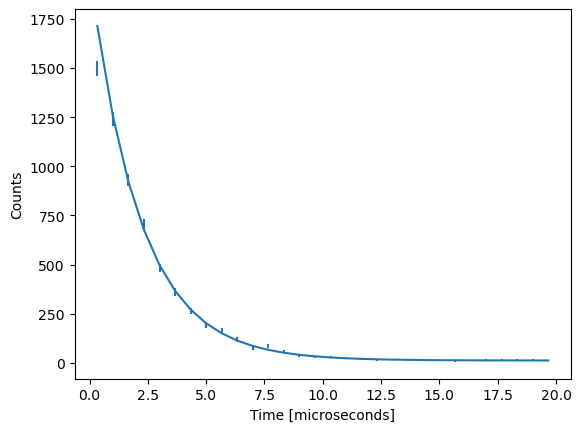

dtau = 0.000; dbackground = 0.02
 50 bins; tau = 2.091+/-0.037 usec
                background = 18.8+/-1.6 counts/usec


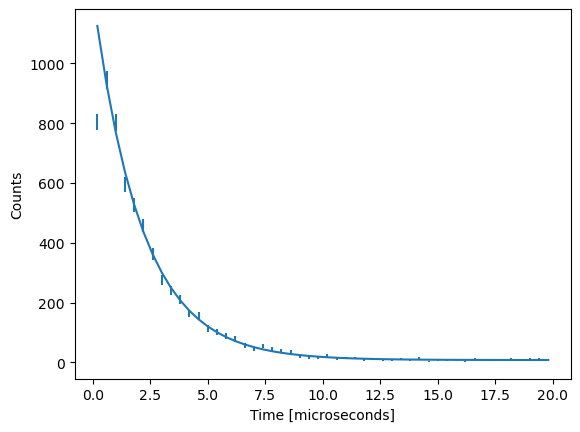

dtau = 0.002; dbackground = -0.01
 70 bins; tau = 2.112+/-0.039 usec
                background = 18.6+/-1.6 counts/usec


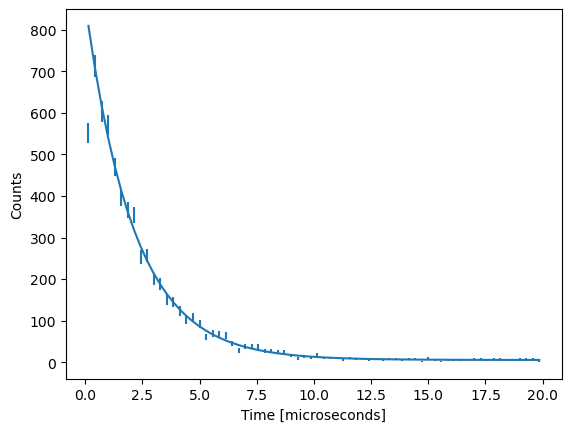

dtau = 0.003; dbackground = -0.05
 90 bins; tau = 2.113+/-0.038 usec
                background = 18.6+/-1.6 counts/usec


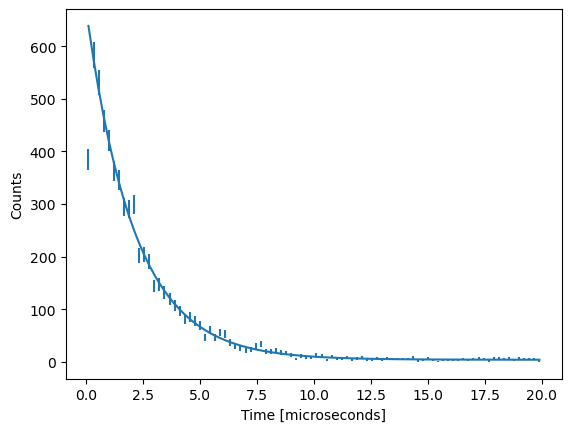

dtau = 0.000; dbackground = -0.01
110 bins; tau = 2.116+/-0.040 usec
                background = 18.6+/-1.6 counts/usec


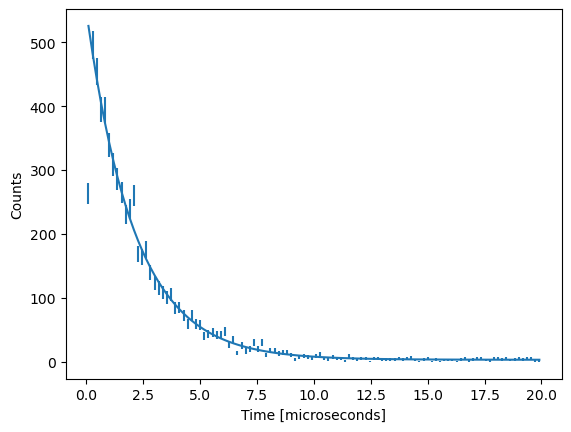

dtau = 0.002; dbackground = 0.06
130 bins; tau = 2.121+/-0.039 usec
                background = 18.4+/-1.6 counts/usec


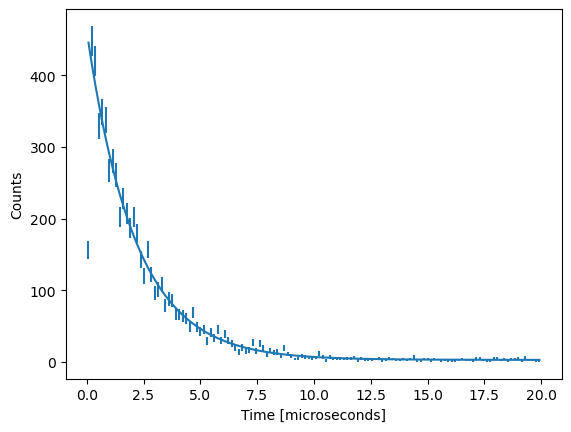

dtau = 0.000; dbackground = -0.01
150 bins; tau = 2.089+/-0.036 usec
                background = 18.9+/-1.6 counts/usec


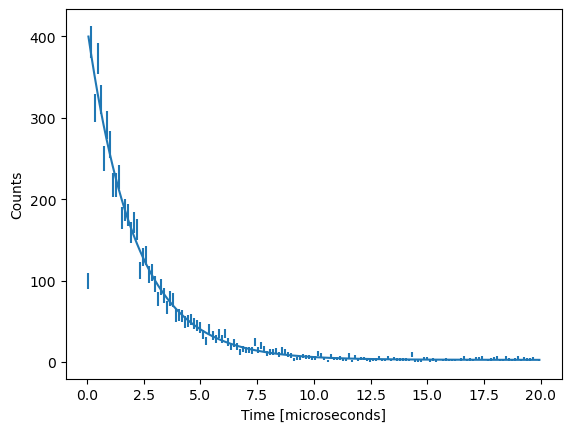

dtau = 0.000; dbackground = 0.01
170 bins; tau = 2.111+/-0.038 usec
                background = 18.6+/-1.6 counts/usec


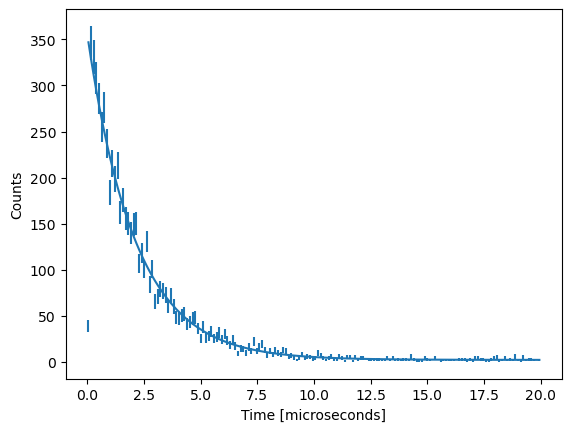

dtau = 0.001; dbackground = 0.04
190 bins; tau = 2.112+/-0.039 usec
                background = 18.6+/-1.6 counts/usec


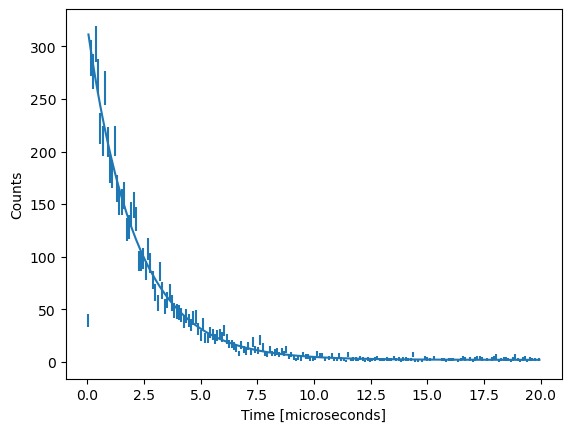


Average tau = 2.110 usec


In [100]:
# Here is some code that I wrote some time ago, incorporating
# many of the above ideas. Use at your on risk!

# Import the optimization code from scipy.

from scipy import optimize

# Define a function that we will fit to the data. The function
# takes an array of values, t, at which to calculate its values, 
# and parameters, a, b, c, that we wish to fit.

# The first function integrates a + b * exp(-c*t) over the bin.
# This is the correct way to do it.

def func(t, a, b, c):
    return a - (b * c / dt) * (np.exp(- (t + dt) / c) - np.exp(-t / c))

# This alternative function just uses the value of a + b * exp(-c*t)
# at the mid-point of the bin. This will give identical results to
# the first function for a and c, but b will differ.

def funcAlt(t, a, b, c):
    return a + b * np.exp(-(t + dt / 2) / c)

# Try various numbers of bins.

sumTau = 0.0
nnBins = 0
for numberOfBins in range(30, 200, 20):
    nnBins += 1
    
    # Re-bin the data.
    
    counts, bins = np.histogram(data[:,0], numberOfBins, (0.0, 20.0))
    dt = bins[1] - bins[0]

    # Find the first bin that is later than the estimated deadtime.
    
    deadtime = 0.4
    startingBin = 0
    for t in bins:
        if t >= deadtime:
            break
        startingBin += 1

# Fitting the function to the data is now as simple as one line, where
# [0, 3000 * dt, 0.5] is an initial guess of the parameters. Note
# that we artificially increase the sigma for counts less than
# 5 per bin, else the fit will be strongly influenced by bins with
# few counts (e.g., in the extreme case of 0 counts, sqrt(n) is
# also zero; really we should use the average count rate for n
# when calculating the Poisson noise)

    sigma = 2. + (counts[startingBin:] > 4) * (-2. + np.sqrt(counts[startingBin:]))
    pars, pars_covariance = optimize.curve_fit(func, 
       bins[startingBin:-1], counts[startingBin:], [0, 3000 * dt, 2.0],
       sigma, absolute_sigma = True)

# We fit the data twice. The second time we improve on the
# estimate of the weighting, by using the fitted count rate.
   
    sigma = np.sqrt(func(bins[startingBin:-1], pars[0], pars[1], pars[2]))
    pars, pars_covariance = optimize.curve_fit(func, 
       bins[startingBin:-1], counts[startingBin:], [0, 3000 * dt, 2.0],
       sigma, absolute_sigma = True) 
    
# Now, the next possible problem is that the curve_fit routine may produce a biased
# estimate of the parameters in the presence of noise. To quantify this
# effect we create a perfect data set from the previous fitted parameters,
# and then we try 1000 trials where we add Poisson noise to it and fit
# the parameters. We then find the deviation from the average fitted
# parameters and the actual parameters, and use this to correct the
# parameters found in the call to curve_fit above.

    y = func(bins[startingBin:-1], pars[0], pars[1], pars[2])
    sigma = np.sqrt(y)
    for n in range(1000):
        yy = np.random.poisson(y)
        pn, pcn = optimize.curve_fit(func, 
           bins[startingBin:-1], yy, [0, 3000 * dt, 2.0],
           sigma, absolute_sigma = True)
        stDev = np.sqrt(np.diag(pcn))
        if n == 0:
            p = pn
            pv = stDev
        else:
            p = np.vstack((p, pn))
            pv = np.vstack((pv, stDev))

    average = np.average(p, axis = 0, weights = pv)

# dtau and dbackground should be zero if curve_fit produced
# unbiased estimates.

    dtau = average[2] - pars[2]
    dbackground = (average[0] - pars[0]) / dt
    print("dtau = {:.3f}; dbackground = {:.2f}".format(dtau, dbackground))

# This is where we adjust the parameters for the bias.
    
    dpar = average - pars
    pars -= dpar

    sumTau += pars[2]
    print("{:3d} bins; tau = {:.3f}+/-{:.3f} usec\n                background = {:.1f}+/-{:.1f} counts/usec".format(numberOfBins, pars[2], stDev[2], pars[0]/dt, stDev[0]/dt))

    plt.errorbar(bins[:-1] + dt / 2, counts, np.sqrt(counts), fmt = 'none')

    plt.plot(bins[:-1] + dt / 2, func(bins[:-1], pars[0], pars[1], pars[2]))
    plt.xlabel("Time [microseconds]")
    plt.ylabel("Counts")
    plt.show()

print("\nAverage tau = {:.3f} usec".format(sumTau / nnBins))

Here are some results from several data files:

|Filename|Muon lifetime [usec]|
|----|------|
|muon.dat   |$2.112\pm0.037$|
|muon1.dat  |$2.088\pm0.037$|
|muon2.dat  |$2.132\pm0.035$|
|muon4.dat  |$2.126\pm0.035$|
|**Average**|$2.114\pm0.025$|

The lifetime in vacuum is 2.197 usec, and in the lab we should see 2.120 usec. So we are doing very well.

Michael Ashley 16 Jun 2019